In [324]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

In [325]:
S=230982
V=600000
W=97500
E=390
EB=39
I=974
IB=97
ICU=18
R=70000

y0 = [S,V,W,E,EB,I,IB,ICU,R]

M = sum(y0)

Rt_base = 3.     # 0. - 3.5
eta = 0.75       # 0.5 - 0.85
kappa = 0.9      # 0.7 - 0.95
sigma = 0.5      # 0.5 - 1.

gamma = 0.1      # 0.088 - 0.1
gamma_ICU = 0.2  # 0.08 - 0.2
delta = 0.0001   # 0.00001 - 0.007
rho = 0.25

omega_v_b = 1./(6*30)
omega_n_b = 1./(12*30)

chi_0 = 0.1

alpha_w = 0.01
alpha_u = 0.01
alpha_R = 0.1

L_w = alpha_w
L_omega_v = 1/k_v
L_omega_n = 1/k_n

e_R = 0.
e_u = 0.
e_w = 0.

Phi_0 = 0.0025*M
phi_0 = 0.0025*M


u_base = 0.5

lamb = 0.01
lamb2 = 6

n = 1.
k_v = M*omega_v_b*(1/(gamma+delta))
k_n = M*omega_n_b*(1/(gamma+delta))

tau = 30*1

mu = 0.267
d_0 = 274
d_mu = 0.

In [326]:
d = {'S':0,'V':1,'W':2,'E':3,'EB':4,'I':5,'IB':6,'ICU':7,'R':8}
def fun(t,y):
    return [dS(t,y), dV(t,y), dW(t,y), dE(t,y), dEB(t,y), dI(t,y), dIB(t,y), dICU(t,y), dR(t,y)]

def dS(t,y):
    return - gamma*Rt(y[d['ICU']],t)*y[d['S']]/M*(y[d['I']]+sigma*y[d['IB']]) \
           - Phi(y[d['ICU']],y[d['S']])*M
def dV(t,y):
    return - (1-eta)*gamma*Rt(y[d['ICU']],t)*y[d['V']]/M*(y[d['I']]+sigma*y[d['IB']]) \
           + M*Phi(y[d['ICU']],y[d['S']]) + y[d['W']]*phi(y[d['ICU']],y[d['W']]) \
           - omega_v(y[d['I']],y[d['IB']])*y[d['V']]
def dW(t,y):
    return + omega_v(y[d['I']],y[d['IB']])*y[d['V']] \
           + omega_n(y[d['I']],y[d['IB']])*y[d['R']] \
           - gamma*Rt(y[d['ICU']],t)*y[d['W']]/M*(y[d['I']]+sigma*y[d['IB']]) \
           - y[d['W']]*phi(y[d['ICU']],y[d['W']])
def dE(t,y):
    return + gamma*Rt(y[d['ICU']],t)*(y[d['S']]+y[d['W']])/M*(y[d['I']]+sigma*y[d['IB']]) \
           - rho*y[d['E']]
def dEB(t,y):
    return + (1-eta)*gamma*Rt(y[d['ICU']],t)*y[d['V']]/M*(y[d['I']]+sigma*y[d['IB']]) \
           - rho*y[d['EB']]
def dI(t,y):
    return + rho*y[d['E']] \
           - (gamma+delta)*y[d['I']]
def dIB(t,y):
    return + rho*y[d['EB']] \
           - (gamma*(1+kappa)+delta*(1-kappa))*y[d['IB']]
def dICU(t,y):
    return + delta*(y[d['I']]+(1-kappa)*y[d['IB']]) \
           - gamma_ICU*y[d['ICU']]
def dR(t,y):
    return + gamma*(y[d['I']]+(1+kappa)*y[d['IB']]) \
           - omega_n(y[d['I']],y[d['IB']])*y[d['R']] \
           + gamma_ICU*y[d['ICU']]


def Rt(ICU, t):
    return Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma(t)

def Phi(ICU,S):
    if u_w(ICU) < u_c(S): return 0
    return min(Phi_0, u_w(ICU)-u_c(S))

def u_w(ICU):
    return u_base + (u_max()-u_base)*(1-np.exp(-alpha_u*ICU-e_u))

def u_c(S):
    return 1 - S/M

def u_max():
    return 1 - chi_0

def phi(ICU,W):
    if w_w(ICU) < 0: return 0
    return min(phi_0, w_w(ICU))

def w_w(ICU):
    return (1-np.exp(-alpha_w*ICU-e_w+lamb))

def new_w_w(ICU):
    return 1/(1+np.exp(-L_w*ICU-e_w+lamb2))

#def w_c(W):
 #   return 1 - W/M

def Gamma(t):
    return 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)

def omega_v(I,IB):
    return omega_v_b*(1-(I_eff(I,IB)**n/((k_v/2)**n+I_eff(I,IB)**n)))

def omega_n(I,IB):
    return omega_n_b*(1-(I_eff(I,IB)**n/((k_n/2)**n+I_eff(I,IB)**n)))

def I_eff(I,IB):
    return I + sigma*IB

In [327]:
t_max = 365
steps = 10000
result = solve_ivp(fun, (0,t_max), y0, t_eval=[(t_max/steps)*x for x in range(steps)])

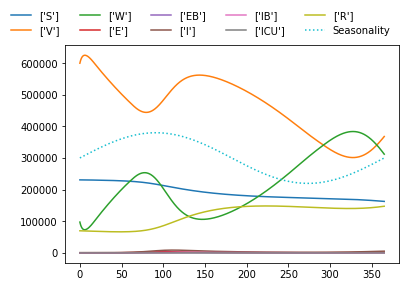

In [328]:
for i,x in enumerate(result["y"]):
    plt.plot(result["t"],x,label=[k for k,v in d.items() if v == i])

plt.plot(result.t, 300000*Gamma(result.t), linestyle=':', label='Seasonality')
plt.legend(bbox_to_anchor=[1, 1.2], ncol=5, frameon=False)
plt.show()




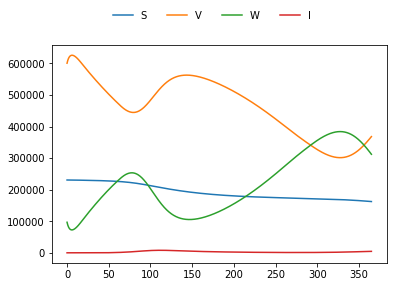

In [332]:
plt.plot(result.t,result.y[0], label='S')
plt.plot(result.t,result.y[1], label='V')
plt.plot(result.t,result.y[2], label='W')
plt.plot(result.t,result.y[5], label='I')
plt.legend(bbox_to_anchor=[0.8, 1.2], ncol=5, frameon=False)
plt.show()

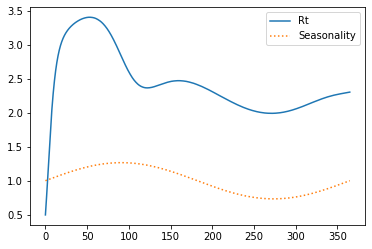

In [330]:
plt.plot(result.t, Rt(result.y[7], result.t), label='Rt')
plt.plot(result.t, Gamma(result.t), linestyle=':', label='Seasonality')

plt.legend()
plt.show()

In [331]:
sum(result['y'])

array([1000000., 1000000., 1000000., ..., 1000000., 1000000., 1000000.])